In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 6 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [3]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

# Change Evidence Sentence in Unrelated Doc

<Axes: >

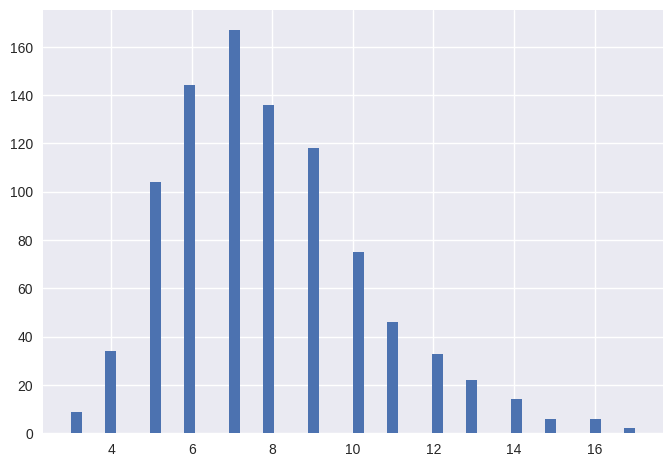

In [26]:
# df = df[df["gold_doc_len"] < 400]
df = df_raw.copy()
df = df.drop_duplicates(subset=["title"])
df = df[df["gold_doc_len"] < 400]
df["sents_len"] = df["sents"].apply(lambda x: len(x))
df = df.sort_values("sents_len").copy()
df[["title", "gold_doc_len", "sents_len"]]
df["sents_len"].hist(bins=50)

In [10]:
df = df_raw.copy()
UNRELATED_SENTS = df.loc[1785]["sents"]
df = df[df["title"] != "Brazil–Pakistan relations"]

def flatten(xss):
    return [x for xs in xss for x in xs]

df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
# Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if l['h'] == label['h'] and l['t'] == label['t']:
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
df = df[df["repeated_label"]]
print(len(df))
df = df.sample(200)

# df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
# df["head_wo_tail_sentence"] = df.apply(lambda r: " ".join(flatten([s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]])), axis=1)

# df["sents_complete_wo_evidence"] = df.apply(lambda r: [s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]], axis=1)
sents_cols = []
for pos in range(15):
    def add_evidence(pos, r):
        sents = UNRELATED_SENTS.copy()
        sents.insert(pos, r["evidence_sents"][0])
        return sents
    df[f"sents_complete_w_evidence_{pos}"] = df.apply(lambda r: " ".join(flatten(add_evidence(pos, r))), axis=1)
    sents_cols.append(f"sents_complete_w_evidence_{pos}")
df[f"sents_complete_w_evidence_{-1}"] = df.apply(lambda r: " ".join(flatten(UNRELATED_SENTS)), axis=1)
sents_cols.append(f"sents_complete_w_evidence_{-1}")
# df["sents_complete_w_beginning"] = df.apply(lambda r: r["head_w_tail_sentence"] + " " + r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], ""), axis=1)

df.head(1)

2450


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,sents_complete_w_evidence_0,sents_complete_w_evidence_1,sents_complete_w_evidence_2,sents_complete_w_evidence_3,sents_complete_w_evidence_4,sents_complete_w_evidence_5,sents_complete_w_evidence_6,sents_complete_w_evidence_7,sents_complete_w_evidence_8,sents_complete_w_evidence_9,sents_complete_w_evidence_10,sents_complete_w_evidence_11,sents_complete_w_evidence_12,sents_complete_w_evidence_13,sents_complete_w_evidence_14,sents_complete_w_evidence_-1
3587,test16298,Where was Vladislav Yuryevich Frolov born?,[Vladislav Frolov],"{'Vladislav Frolov': {'text': 'Vladislav Yuryevich Frolov ( ) ( born 25 January 1980 in Tambov ) is a Russian sprint athlete . He won the silver medal in the 400 metres at the 2006 European Athletics Championships in Gothenburg , running a personal bes...","{'len': 1000, 'max': 380.828857421875, 'min': 368.4882507324219, 'std': 1.2452955295174442, 'mean': 369.9187476501465, 'median': 369.62255859375}",{'Vladislav Frolov': 380.828857421875},"{'Vladislav Frolov': 380.828857421875, 'Ilia Frolov': 375.81134033203125, 'Vladislav Kovalsky': 374.84185791015625, 'Vasili III of Russia': 374.8088684082031, 'Leonid Pervomayskiy': 374.32867431640625, 'Mitya Fomin': 374.0419616699219, 'Ivan Yuvachov':...","{'Vladislav Frolov': {'text': 'Vladislav Yuryevich Frolov ( ) ( born 25 January 1980 in Tambov ) is a Russian sprint athlete . He won the silver medal in the 400 metres at the 2006 European Athletics Championships in Gothenburg , running a personal bes...",test16298,Vladislav Frolov,"[[{'type': 'PER', 'pos': [0, 1], 'name': 'Frolov', 'sent_id': 5, 'global_pos': [129, 129], 'index': '0_0'}, {'name': 'Vladislav Yuryevich Frolov', 'pos': [0, 3], 'sent_id': 0, 'type': 'PER', 'global_pos': [0, 0], 'index': '0_1'}], [{'type': 'TIME', 'po...","[{'r': 'P27', 'h': 11, 't': 3, 'evidence': [0, 2, 3, 4]}, {'r': 'P27', 'h': 12, 't': 3, 'evidence': [0, 2, 3, 4]}, {'r': 'P27', 'h': 13, 't': 3, 'evidence': [0, 2, 3, 4]}, {'r': 'P27', 'h': 16, 't': 15, 'evidence': [3]}, {'r': 'P27', 'h': 19, 't': 3, '...","[[Vladislav, Yuryevich, Frolov, (, ), (, born, 25, January, 1980, in, Tambov, ), is, a, Russian, sprint, athlete, .], [He, won, the, silver, medal, in, the, 400, metres, at, the, 2006, European, Athletics, Championships, in, Gothenburg, ,, running, a, ...",test,"{'r': 'P19', 'h': 0, 't': 2, 'evidence': [0]}",8,"[{'type': 'PER', 'pos': [0, 1], 'name': 'Frolov', 'sent_id': 5, 'global_pos': [129, 129], 'index': '0_0'}, {'name': 'Vladislav Yuryevich Frolov', 'pos': [0, 3], 'sent_id': 0, 'type': 'PER', 'global_pos': [0, 0], 'index': '0_1'}]","[{'name': 'Tambov', 'pos': [11, 12], 'sent_id': 0, 'type': 'LOC', 'global_pos': [11, 11], 'index': '2_0'}]","{Vladislav Yuryevich Frolov, Frolov}",{Tambov},Vladislav Yuryevich Frolov,Tambov,{PER},{LOC},[0],"[[Vladislav, Yuryevich, Frolov, (, ), (, born, 25, January, 1980, in, Tambov, ), is, a, Russ

In [11]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

def flatten(xss):
    return [x for xs in xss for x in xs]
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot2 = df.copy()


  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/16 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/dragon-roberta-query-encoder:   0%|          | 0/16 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever-msmarco:   0%|          | 0/16 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever:   0%|          | 0/16 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_2722836/3923951085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = embds_dot


Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_2722836/3923951085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = embds_dot
/tmp/ipykernel_2722836/3923951085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = embds_dot
/tmp/ipykernel_2722836/3923951085.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.co

  0%|          | 0/19200 [00:00<?, ?it/s]

,Model,sent_col,Evidence Sentence Position,dot,Normalized Dot Product Similarity
0,Dragon+,sents_complete_w_evidence_0,1,365.281250,0.408978
1,Dragon RoBERTa,sents_complete_w_evidence_0,1,341.616974,0.413172
2,Contriever MSMARCO,sents_complete_w_evidence_0,1,1.404121,0.794788
3,Contriever,sents_complete_w_evidence_0,1,0.886968,0.631900
4,COCO-DR Base MSMARCO,sents_complete_w_evidence_0,1,210.041550,0.713389
...,...,...,...,...,...
19195,Dragon RoBERTa,sents_complete_w_evidence_-1,0,324.973572,0.203436
19196,Contriever MSMARCO,sents_complete_w_evidence_-1,0,0.450457,0.099591
19197,Contriever,sents_complete_w_evidence_-1,0,0.366062,0.151996
19198,COCO-DR Base MSMARCO,sents_complete_w_evidence_-1,0,198.663834,0.165219


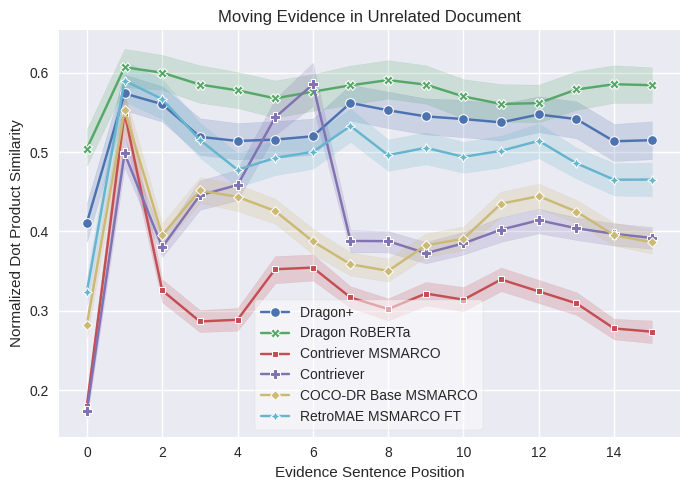

In [12]:
df = df_dot2.copy()
df.head(3)
dfr = []
for row in df.to_dict(orient="records"):
    for sent_col in sents_cols:
        for query_model, context_model, POOLING in cfgs:
            new_col = f"{query_model}_{sent_col}_dot"
            dfr.append({
                "query_model": query_model,
                "sent_col": sent_col,
                "evidence_pos": int(sent_col.split("_")[-1]) + 1,
                "dot": row[new_col],
            })
dfr = pd.DataFrame(dfr)

model_mins = {}
model_maxs = {}
dot_n = []
for row in tqdm(dfr.to_dict(orient="records")):
    if row["query_model"] not in model_mins:
        model_mins[row["query_model"]] = dfr[dfr["query_model"] == row["query_model"]]["dot"].min()
        model_maxs[row["query_model"]] = dfr[dfr["query_model"] == row["query_model"]]["dot"].max()
    dot_n.append((row["dot"] - model_mins[row["query_model"]]) / (model_maxs[row["query_model"]] - model_mins[row["query_model"]]))
dfr["dot_normalized"] = dot_n

model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
dfr["query_model"] = dfr["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])

dfr.rename(columns={"dot_normalized": "Normalized Dot Product Similarity", "evidence_pos": "Evidence Sentence Position", "query_model": "Model"}, inplace=True)

plt.figure(figsize=(7, 5))
sns.lineplot(dfr, x="Evidence Sentence Position", y="Normalized Dot Product Similarity", hue="Model", style="Model", markers=True, dashes=False)
plt.legend(frameon=True, facecolor='white', framealpha=0.5)
# plt.xticks([i for i in range(1, )])
plt.title("Moving Evidence in Unrelated Document")
plt.tight_layout()
plt.savefig("figs/position_evidence_dot.pdf")
dfr

# Change Evidence Sentence Pos

In [4]:
df = df_raw.copy()
def flatten(xss):
    return [x for xs in xss for x in xs]

df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
# Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if l['h'] == label['h'] and l['t'] == label['t']:
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
df = df[df["repeated_label"]]

df["sents_len"] = df["sents"].apply(lambda x: len(x))
df = df[df["sents_len"] > 5]

print(len(df))
# df = df.sample(1000)

df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
# df["head_wo_tail_sentence"] = df.apply(lambda r: " ".join(flatten([s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]])), axis=1)

df["sents_complete_wo_evidence"] = df.apply(lambda r: [s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]], axis=1)
sents_cols = []
for pos in range(10):
    def add_evidence(pos, r):
        sents = r["sents_complete_wo_evidence"].copy()
        sents.insert(pos, r["evidence_sents"][0])
        return sents
    df[f"sents_complete_w_evidence_{pos}"] = df.apply(lambda r: " ".join(flatten(add_evidence(pos, r))), axis=1)
    sents_cols.append(f"sents_complete_w_evidence_{pos}")
df[f"sents_complete_w_evidence_{-1}"] = df.apply(lambda r: " ".join(flatten(r["sents_complete_wo_evidence"])), axis=1)
sents_cols.append(f"sents_complete_w_evidence_{-1}")
# df["sents_complete_w_beginning"] = df.apply(lambda r: r["head_w_tail_sentence"] + " " + r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], ""), axis=1)

df.head(1)

2021


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,sents_len,sents_complete,sents_complete_wo_evidence,sents_complete_w_evidence_0,sents_complete_w_evidence_1,sents_complete_w_evidence_2,sents_complete_w_evidence_3,sents_complete_w_evidence_4,sents_complete_w_evidence_5,sents_complete_w_evidence_6,sents_complete_w_evidence_7,sents_complete_w_evidence_8,sents_complete_w_evidence_9,sents_complete_w_evidence_-1
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MIS

In [5]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

def flatten(xss):
    return [x for xs in xss for x in xs]
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot2 = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/133386 [00:00<?, ?it/s]

,Model,sent_col,Evidence Sentence Position,dot,Normalized Dot Product Similarity
0,Dragon+,sents_complete_w_evidence_0,1,390.111328,0.635483
1,Dragon RoBERTa,sents_complete_w_evidence_0,1,375.253601,0.552708
2,Contriever MSMARCO,sents_complete_w_evidence_0,1,1.373514,0.496016
3,Contriever,sents_complete_w_evidence_0,1,0.875849,0.483947
4,COCO-DR Base MSMARCO,sents_complete_w_evidence_0,1,212.830215,0.575972
...,...,...,...,...,...
133375,Dragon RoBERTa,sents_complete_w_evidence_9,10,360.668243,0.435208
133376,Contriever MSMARCO,sents_complete_w_evidence_9,10,1.564123,0.589577
133377,Contriever,sents_complete_w_evidence_9,10,1.046665,0.607671
133378,COCO-DR Base MSMARCO,sents_complete_w_evidence_9,10,212.588013,0.565891


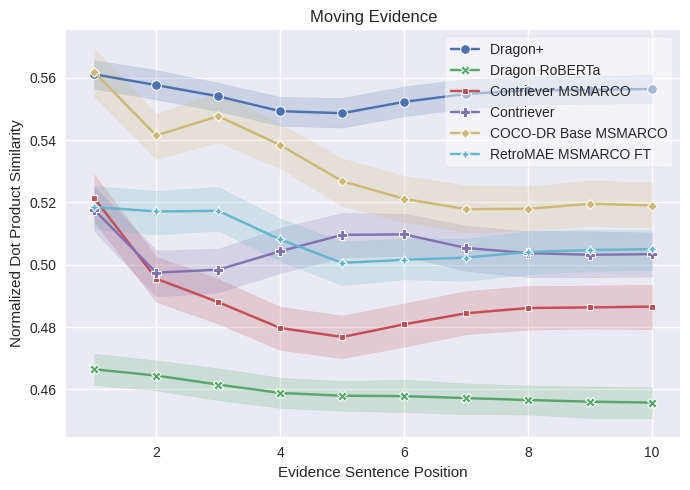

In [46]:
df = df_dot2.copy()
df.head(3)
dfr = []
for row in df.to_dict(orient="records"):
    for sent_col in sents_cols:
        for query_model, context_model, POOLING in cfgs:
            new_col = f"{query_model}_{sent_col}_dot"
            dfr.append({
                "query_model": query_model,
                "sent_col": sent_col,
                "evidence_pos": int(sent_col.split("_")[-1]) + 1,
                "dot": row[new_col],
            })
dfr = pd.DataFrame(dfr)

model_mins = {}
model_maxs = {}
dot_n = []
for row in tqdm(dfr.to_dict(orient="records")):
    if row["query_model"] not in model_mins:
        model_mins[row["query_model"]] = dfr[dfr["query_model"] == row["query_model"]]["dot"].min()
        model_maxs[row["query_model"]] = dfr[dfr["query_model"] == row["query_model"]]["dot"].max()
    dot_n.append((row["dot"] - model_mins[row["query_model"]]) / (model_maxs[row["query_model"]] - model_mins[row["query_model"]]))
dfr["dot_normalized"] = dot_n

model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
dfr["query_model"] = dfr["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
dfr.rename(columns={"dot_normalized": "Normalized Dot Product Similarity", "evidence_pos": "Evidence Sentence Position", "query_model": "Model"}, inplace=True)

dfr = dfr[dfr["Evidence Sentence Position"] != 0]

plt.figure(figsize=(7, 5))
sns.lineplot(dfr, x="Evidence Sentence Position", y="Normalized Dot Product Similarity", hue="Model", style="Model", markers=True, dashes=False)
plt.legend(frameon=True, facecolor='white', framealpha=0.5)
# plt.xticks([i for i in range(1, )])
plt.title("Moving Evidence")
plt.tight_layout()
plt.savefig("figs/position_evidence_dot.pdf")
dfr

# Evidence First vs Last

In [29]:
df = df_raw.copy()
def flatten(xss):
    return [x for xs in xss for x in xs]

df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
df = df[df["head_entity_in_evidence"].str.len() >= 1]  # 1 Head in Evidence
# Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if l['h'] == label['h'] and l['t'] == label['t']:
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
df = df[df["repeated_label"]]
print(len(df))

df = df.sample(250, random_state=0)
print(len(df))

df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
# df["head_wo_tail_sentence"] = df.apply(lambda r: " ".join(flatten([s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]])), axis=1)

df["sents_complete_wo_evidence"] = df.apply(lambda r: [s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]], axis=1)
sents_cols = []
def add_evidence(pos, r):
    sents = r["sents_complete_wo_evidence"].copy()
    if pos == -1:
        pos = len(sents)
    sents.insert(pos, r["evidence_sents"][0])
    return sents

df[f"sents_complete_w_evidence_first"] = df.apply(lambda r: " ".join(flatten(add_evidence(0, r))), axis=1)
df[f"sents_complete_w_evidence_last"] = df.apply(lambda r: " ".join(flatten(add_evidence(-1, r))), axis=1)
sents_cols.append(f"sents_complete_w_evidence_first")
sents_cols.append(f"sents_complete_w_evidence_last")

df.head(1)

2265
250


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,sents_complete,sents_complete_wo_evidence,evidence_text,sents_complete_w_evidence_first,sents_complete_w_evidence_last
195,test840,Which record label is The Eminem Show associated with?,[The Eminem Show],"{'The Eminem Show': {'text': 'The Eminem Show is the fourth studio album by American rapper Eminem , released on May 26 , 2002 by Aftermath Entertainment , Shady Records , and Interscope Records . The Eminem Show includes the commercially successful singles "" Without Me "" , "" Cleanin ' Out My Closet "" , "" Superman "" , and "" Sing for the Moment "" . The Eminem Show reached number one in nineteen countries , including Australia , Canada , the United Kingdom and the United States , and was the best - selling album of 2002 in the United States , with 7,600,000 copies sold . Since its release in 2002 , the album has sold 10,600,000 copies in the United States and over 30 million copies worldwide . At the 2003 Grammy Awards , it was nominated for Album of the Year and became Eminem 's third a...","{'len': 1000, 'max': 394.72601318359375, 'min': 384.6041564941406, 'std': 1.553564952206845, 'mean': 386.24647219848634, 'median': 385.7506408691406}",{'The Eminem Show': 394.72601318359375},"{'The Eminem Show': 394.72601318359375, 'Fondle 'Em Records': 393.05426025390625, 'Shady XV': 392.7562255859375, 'Curtain Call: The Hits': 392.6048278808594, 'Def Jam Recordings': 392.4776916503906, 'Capitol Music Group': 392.2601318359375, 'Relapse (Eminem album)': 392.1006164550781, 'EOne Music discography': 392.06988525390625, 'Farmclub.com': 391.7013854980469, 'School Boy Records': 391.34173583984375, 'Rap Name': 390.90496826171875, 'So Far...': 390.8753967285156, 'Esham': 390.8587646484375, 'El-P discography': 390.7080078125, 'Apple Records discography': 390.6126403808594, 'Helicon Records': 390.3676452636719, 'Innocent Records': 390.3555603027344, 'Astralwerks': 390.28240966796875, 'Regular Records': 390.2742614746094, 'Oxygen Music Works': 390.2027893066406, 'The Mark, Tom, and ...","{'The Eminem Show': {'text': 'The Eminem Show is the fourth studio album by American rapper Eminem , released on May 26 , 2002 by Aftermath Entertainment , Shady Records , and Interscope Records . The Eminem Show includes the commercially successful singles "" Without Me "" , "" Cleanin ' Out My Closet "" , "" Superman "" , and "" Sing for the Moment "" . The Eminem Show reached number one in nineteen countries , including Australia , Canada , the United Kingdom and the United States , and was the best - selling album of 2002 in the United States , with 7,600,000 copies sold . Since its release in 2002 , the album has sold 10,600,000 copies in the United States and over 30 million copies worldwide . At the 2003 Grammy Awards , it was nominated for Album of the Year and became Eminem 's third a...",test840,The Eminem Show,"[[{'pos': [0, 3], 'type': 'MISC', 's

In [30]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

def flatten(xss):
    return [x for xs in xss for x in xs]
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low,ttest_ci_high,mean_diff,std_diff,n
0,Contriever,facebook/contriever_sents_complete_w_evidence_first_dot,facebook/contriever_sents_complete_w_evidence_last_dot,3.878389,1.346239e-04,1.650996,1.650996,0.019183,0.078205,250
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_first_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_complete_w_evidence_last_dot,5.353745,1.956559e-07,1.650996,1.650996,0.671721,1.983816,250
0,Dragon+,facebook/dragon-plus-query-encoder_sents_complete_w_evidence_first_dot,facebook/dragon-plus-query-encoder_sents_complete_w_evidence_last_dot,8.579329,1.037295e-15,1.650996,1.650996,0.760481,1.401539,250
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_sents_complete_w_evidence_first_dot,OpenMatch/cocodr-base-msmarco_sents_complete_w_evidence_last_dot,10.468416,1.724497e-21,1.650996,1.650996,1.223269,1.847613,250
0,Contriever MSMARCO,facebook/contriever-msmarco_sents_complete_w_evidence_first_dot,facebook/contriever-msmarco_sents_complete_w_evidence_last_dot,12.368144,1.035151e-27,1.650996,1.650996,0.084006,0.107393,250
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_sents_complete_w_evidence_first_dot,facebook/dragon-roberta-query-encoder_sents_complete_w_evidence_last_dot,17.240926,2.268466e-44,1.650996,1.650996,1.509220,1.384083,250


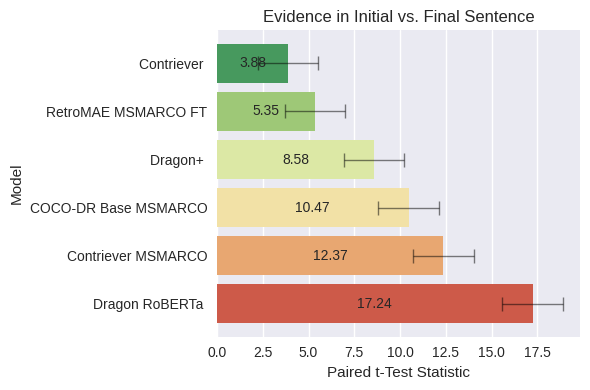

In [31]:
df = df_dot.copy()

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_sents")[0] and query_model == col2.split("_sents")[0] and col1 != col2 and "first" in col1:
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                    "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)
plt.figure(figsize=(6, 4))
plt.title("Evidence in Initial vs. Final Sentence")
ax = sns.barplot(data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn_r"), hue="Model")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
results_df.to_json("results/position_df.json", orient="records")
# ax.bar_label(ax.containers[0], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')
# ax.bar_label(ax.containers[1], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')

plt.tight_layout()
plt.savefig("figs/initial_final_evidence_ttest.pdf")
results_df

In [40]:
# Find Example
pd.set_option('display.max_colwidth', 1800)
df = df_dot.copy()
df["diff"] = df["facebook/dragon-plus-query-encoder_sents_complete_w_evidence_first_dot"] - df["facebook/dragon-plus-query-encoder_sents_complete_w_evidence_last_dot"]
df["evidence_text"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
df["evidence_len"] = df["evidence_text"].apply(lambda x: len(x.split()))
print(df["evidence_len"].describe())
df = df[df["evidence_len"] < 20]
df[sents_cols + ["title", "query", "evidence_text", "gold_doc_len", "diff"]].sort_values("diff", ascending=False)

count    250.000000
mean      32.104000
std       14.179188
min        8.000000
25%       22.000000
50%       30.000000
75%       38.000000
max       89.000000
Name: evidence_len, dtype: float64


,sents_complete_w_evidence_first,sents_complete_w_evidence_last,title,query,evidence_text,gold_doc_len,diff
2367,"Wolfgang Thüne ( born 8 October 1949 ) is a German former gymnast . He competed at the 1972 Summer Olympics in all artistic gymnastics events and won a bronze medal with the East German team . Individually his best achievement was seventh place in the horizontal bar . He won two more bronze team medals at the world championships in 1970 and 1974 as well as individual silver in the horizontal bar in 1974 . At the 1975 European championships in Bern , he fled to West Germany with the help of his rival Eberhard Gienger . In 1977 he won the national all - round title in West Germany competing for TuS 04 Leverkusen . After retirement he worked as a gymnastics coach at the same club .","He competed at the 1972 Summer Olympics in all artistic gymnastics events and won a bronze medal with the East German team . Individually his best achievement was seventh place in the horizontal bar . He won two more bronze team medals at the world championships in 1970 and 1974 as well as individual silver in the horizontal bar in 1974 . At the 1975 European championships in Bern , he fled to West Germany with the help of his rival Eberhard Gienger . In 1977 he won the national all - round title in West Germany competing for TuS 04 Leverkusen . After retirement he worked as a gymnastics coach at the same club . Wolfgang Thüne ( born 8 October 1949 ) is a German former gymnast .",Wolfgang Thüne,When was Wolfgang Thüne born?,Wolfgang Thüne ( born 8 October 1949 ) is a German former gymnast .,132,7.190887
155,"Elsa Wiezell ( 1926 – 2014 ) , poet , teacher , artist This is a list of women writers who were born in Paraguay or whose writings are closely associated with that country . Dora Acuña ( 1903 – 1987 ) , poet , journalist , radio presenter Gladys Carmagnola ( born 1939 ) , acclaimed poet , works for adults and children Raquel Chaves ( born 1939 ) , poet , journalist , educator Susy Delgado ( born 1949 ) , poet , writes in Spanish and Guarani Renée Ferrer de Arréllaga ( born 1944 ) , poet , novelist Josefina Pla ( 1903 – 1999 ) , Spanish - born Paraguayan poet , playwright , critic , journalist Mercedes Sandoval de Hempel ( 1919 – 2005 ) , lawyer , feminist , legal writings Carmen Soler ( 1924 – 1985 ) , poet , educator , moved to Argentina Faith Wilding ( born 1943 ) , Paraguayan - American feminist artist , non - fiction writer , educator","This is a list of women writers who were born in Paraguay or whose writings are closely associated with that country . Dora Acuña ( 1903 – 1987 ) , poet , journalist , radio presenter Gladys Carmagnola ( born 1939 ) , acclaimed poet , works for adults and children Raquel Chaves ( born 1939 ) , poet , journalist , educator Susy Delgado ( born 1949 ) , poet , writes in Spanish and Guarani Renée Ferrer de Arréllaga ( born 1944 ) , poet , novelist Josefina Pla ( 1903 – 1999 ) , Spanish - born Paraguayan poet , playwright , critic , journalist Mercedes Sandoval de Hempel ( 1919 – 2005 ) , lawyer , feminist , legal writings Carmen Soler ( 1924 – 1985 ) , poet , educator , moved to Argentina Faith Wilding ( born 1943 ) , Paraguayan - American feminist artist , non - fiction writer , educator Elsa Wiezell ( 1926 – 2014 ) , poet , teacher , artist",List of Paraguayan women writers,When was Elsa Wiezell born?,"Elsa Wiezell ( 1926 – 2014 ) , poet , teacher , artist",176,4.042633
2922,"Louis Moreau Gottschalk , New Orleans , United States ( 1829 – 1869 ) This is a list of composers of Caribbean descent . The Caribbean is a region consisting of the Caribbean Sea , its islands ( most of which are enclosed by the sea ) , and the surrounding coasts . The region is located southeast of the Gulf of Mexico and North America , east of Central America , and to the north of South America . The Caribbean has produced many notable composers , who have contributed in a variety of ways to the history of Western classical mu

# Without Changing Data

In [ ]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

df = df_raw.copy()
def flatten(xss):
    return [x for xs in xss for x in xs]
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))

plot_col_dots = []
for query_model, context_model, POOLING in cfgs:
    dpr = YourCustomDEModel(query_model, context_model, POOLING)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    
    embds = dpr.encode_corpus(to_doc_format(df['sents_complete'].to_list()))
    query_embds = dpr.encode_queries(df['query'].to_list())
    embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
    new_col = f"{query_model}_dot"
    print(new_col)
    df[new_col] = embds_dot
    plot_col_dots.append(new_col)
    
df_dot = df.copy()

In [ ]:
def analyze_pos(dfc):
    df = dfc.copy()
    df["cumsum_sent_len"] = df["sents"].apply(lambda x: np.cumsum([0] + [len(s) for s in x]))
    df["heads_pos"] = df.apply(lambda r: [h["pos"][0] + r["cumsum_sent_len"][h["sent_id"]] for h in r["head_entity"]], axis=1)
    df["first_head_pos"] = df["heads_pos"].apply(lambda x: min(x))
    # df = df[df["first_head_pos"] < 50]
    df["first_head_pos_relative"] = 100 * df["first_head_pos"] / df["sents"].apply(lambda x: len(flatten(x)))
    df["first_head_pos_relative"] = df["first_head_pos_relative"].astype(int)
    # df["first_head_pos_relative"] = pd.cut(df["first_head_pos_relative"], bins=[-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    df["first_head_pos_relative"] = pd.cut(df["first_head_pos_relative"], bins=[-1, 5, 10, 20, 30, 100], labels=[0, 5, 10, 20, 30,])
    
    for col in plot_col_dots:
        df[col+"_normalized"] = (df[col] - df[col].min()) / (df[col].max() + df[col].min())
        sns.lineplot(data=df, x="first_head_pos_relative", y=col+"_normalized", label=col+"_normalized", marker="o")
        # plt.show()
    return df.head(1)

analyze_pos(df_dot)

In [ ]:
def analyze_pos(dfc):
    df = dfc.copy()
    df["evidence_sent_id"] = df["evidence_sent_ids"].apply(lambda x: x[0])
    df["evidence_sent_id_relative"] = 100 * df["evidence_sent_id"] / df["sents"].apply(lambda x: len(x))
    # df["first_head_pos_relative"] = pd.cut(df["first_head_pos_relative"], bins=[-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    df["evidence_sent_id_relative"] = pd.cut(df["evidence_sent_id_relative"], bins=[-1, 5, 10, 20, 30, 100], labels=[0, 5, 10, 20, 30,])
    
    for col in plot_col_dots:
        df[col+"_normalized"] = (df[col] - df[col].min()) / (df[col].max() + df[col].min())
        sns.lineplot(data=df, x="evidence_sent_id_relative", y=col+"_normalized", label=col+"_normalized", marker="o")
        # plt.show()
    return df.head(1)

analyze_pos(df_dot)

In [ ]:
df